# Contexto do Problema

A **Olist** é uma startup brasileira que atua no segmento de e-commerce, sobretudo por meio de marketplace.

De um lado, a olist concentra vendedores que desejam anunciar em marketplaces como Mercado Livre, B2W, Via Varejo e Amazon. Do outro lado, concentra os produtos de todos os vendedores em uma loja única que fica visível ao consumidor final.

# Problema

A diretoria da empresa viu que grande parte dos clientes acabavam justificando que não finalizaram a compra por não possuir dinheiro no momento e não possuir cartão de crédito para parcelar.

A empresa decidiu criar um cartão de crédito próprio para oferecer aos seus clientes, com o objetivo de alavancar as vendas, impedindo que os clientes deixem de comprar por não possuir um cartão.

Em primeiro momento, a estratégia é identificar, em sua base, quem são os clientes que costumam pagar com cartão de crédito de bancos e que não possuem cartão para enviar um email marketing oferencendo 15% de desconto em compras usando o novo cartão da Olist.

**O principal ponto é identificar quem são os clientes que receberão os emails**.

# 0.0 IMPORTS

In [69]:
# manipulação de dados e calculos
import pandas as pd
import numpy as np

# visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# validacao
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

# config warnings
import warnings
warnings.filterwarnings('ignore')

1. Validação (muitos dados) OK
2. Conclusão 
3. Validação Comite

## 0.1 Funções Auxilares

In [57]:
# função para validação
def plot_metric(y_true, yhat, model_name):
    
    matrix = np.round(confusion_matrix(y_true, yhat), 1)
    palette = ['#67b79e', '#fda664']

    # show metric
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(matrix, annot=True, cmap='Greens')
    plt.title('Confusion Matrix')

    # figure with real data
    plt.subplot(1, 3, 2)
    sns.countplot(x=y_true, palette=palette, ec='k')
    plt.title('Forma de Pagamento - (REAL)')
    plt.xlabel('Pagamento - 1 = Crédito | 0 = Outros')
    sns.despine(right=True)

    # figure with prediction
    plt.subplot(1, 3, 3)
    pred = pd.Series(yhat).value_counts()
    sns.barplot(x=pred.index, y=pred.values, palette=palette, ec='k')
    plt.title('Forma de Pagamento - (Predição)')
    plt.xlabel('Pagamento - 1 = Crédito | 0 = Outros')
    sns.despine(right=True)
    plt.suptitle(model_name);
    
    

# Função para calcular metricas
def compute_metrics(yhat, y_validation, model_name):
    
    metric = pd.DataFrame(
        {'Model_name': model_name,
         'Accuracy': accuracy_score(y_validation, yhat),
         'Precision': precision_score(y_validation, yhat),
         'Recall': recall_score(y_validation, yhat)
        }, index=[0])
    
    return metric

## 0.2 Carregamento de Dados

Ao todo, usaremos 8 tabelas/arquivos que foi tirada de um banco de dados. Cada tabela se relaciona através de um Id.

In [3]:
# arquivos/tabelas usadas
tb_customer    = pd.read_csv('data/olist_customers_dataset.csv') 
tb_geolacation = pd.read_csv('data/olist_geolocation_dataset.csv').rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix'}) 
tb_items       = pd.read_csv('data/olist_order_items_dataset.csv')
tb_payment     = pd.read_csv('data/olist_order_payments_dataset.csv') 
tb_order       = pd.read_csv('data/olist_orders_dataset.csv') 
tb_product     = pd.read_csv('data/olist_products_dataset.csv')
tb_seller      = pd.read_csv('data/olist_sellers_dataset.csv').rename(columns={'seller_zip_code_prefix': 'zip_code_prefix'})

Para ajuntar as informações dos relacionamentos das tabelas/arquivos, vamos fazer um merge dos ID´s.

In [4]:
# ajuntando através dos relacionamentos
df1  = pd.merge(tb_payment, tb_order, on='order_id', how='left')
df2  = pd.merge(df1, tb_customer, on='customer_id', how='left')
df3  = pd.merge(df2, tb_items, on='order_id', how='left')
df4  = pd.merge(df3, tb_product, on='product_id', how='left')
df5  = pd.merge(df4, tb_seller, on='seller_id', how='left')
data = pd.merge(df5, tb_geolacation, on='zip_code_prefix', how='left')

Na tabela de pagamentos, há uma variavel (**payment_type**) com as informações históricas sobre a forma de pagamento que o cliente usou. Entre as opções, há se ele pegou com cartão de crédito, boleto, voucher, débito, entre outros.

Para prevermos se o cliente irá pagar com crédito ou não, transformaremos a variavel para binaria. Exemplo: se pagamento == 'cartao de credito' tranforma em 1. Se não, transforma em 0.

In [5]:
# criando variavel target -> if pagamento = credito: 1, else: 0
PAGAMENTO_CREDITO = 1
OUTROS_PAGAMENTOS = 0

# atualizando a colunas com os novos valores
data['payment_type'] = np.where(
    data['payment_type']=='credit_card',
    PAGAMENTO_CREDITO, OUTROS_PAGAMENTOS
)

O conjunto de dados completo possui mais de 16 Milhões de linhas, ao rodar estava dando erro de memoria, sendo impossóvel de executar as céluas de códigos. Portanto, diminuiremos o dataset para 5 Milhões de linhas.

In [6]:
len(data.columns)

37

In [7]:
quantidade_linha_nova = 5000000 
data = data.sample(quantidade_linha_nova, random_state=42).copy()

# 1.0 DESCRIÇÃO DE DADOS

In [8]:
classe1 = data[data['payment_type'] == 1].copy() # dados de cartao de credito
classe0 = data[data['payment_type'] == 0].copy() # dados de nao cartao de credito

QTD_CLASSE = 1301591
nova_classe1 = classe1.sample(QTD_CLASSE) # filtrando 1301591 linhas da classe 1
data = pd.concat([classe0, nova_classe1], axis=0).copy() # ajuntando nova quantidade da classe 1 com a classe 0

## 1.1 Dimensão de Dados

In [9]:
qty_rows    = data.shape[0]  # quantidade de linhas
qty_columns = data.shape[1]  # quantidade de colunas

# mostrando quantidade de linhas e colunas
print('Qty. columns:', qty_columns)
print('Qty. rows:', qty_rows)

Qty. columns: 37
Qty. rows: 2603182


## 1.2 Tipo de Dados

In [10]:
# verificando tipo das variaveis
data.dtypes

order_id                          object
payment_sequential                 int64
payment_type                       int32
payment_installments               int64
payment_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
product_category_name             object
product_name_lenght              float64
product_descript

## 1.3 Dados Ausentes/Nulos

In [11]:
data.isna().sum()

order_id                             0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                  652
order_delivered_carrier_date     28902
order_delivered_customer_date    57560
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                      140
product_id                         140
seller_id                          140
shipping_limit_date                140
price                              140
freight_value                      140
product_category_name            37220
product_name_lenght              37220
product_description_lenght       37220
product_photos_qty       

## 1.4 Tratamento de Dados Nulos

Como o dataset possui uma grande quantidade de registros (16 milhões), excluir os valores ausentes não fará tanto falto devido a pequena proporção que representa do conjunto de dados.

In [12]:
# excluindo valores ausentes/nulos
data.dropna(inplace=True)

# verificando nova quantidade de valores ausentes/nulos
data.isna().sum()

order_id                         0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm   

## 1.5 Estatistica Descritiva

In [13]:
data[['payment_sequential', 'payment_value', 'price', 'freight_value',
       'product_height_cm', 'product_width_cm', 'seller_state',
       'product_category_name']].describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
payment_sequential,2509209.0,1.2,0.9,1.0,1.0,1.0,1.0,26.0
payment_value,2509209.0,164.1,239.7,0.0,57.3,102.3,180.4,13664.1
price,2509209.0,112.6,165.4,0.8,39.9,69.9,126.6,6735.0
freight_value,2509209.0,19.8,14.8,0.0,13.3,16.2,20.8,409.7
product_height_cm,2509209.0,16.4,13.2,2.0,9.0,13.0,20.0,105.0
product_width_cm,2509209.0,23.5,11.4,6.0,15.0,20.0,30.0,118.0


# 2.0 EDA

## 2.1 Análise Univariada

### 2.1.1 Variavel Target

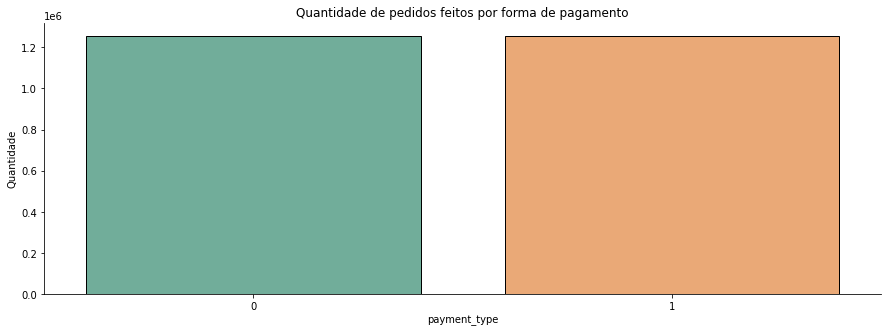

In [14]:
plt.figure(figsize=(15, 5))
sns.countplot(x='payment_type', data=data, palette=['#67b79e', '#fda664'], ec='k')
sns.despine(right=True)
plt.title('Quantidade de pedidos feitos por forma de pagamento')
plt.ylabel('Forma de pagamento')
plt.ylabel('Quantidade');

### 2.1.2 Variavel Numérica

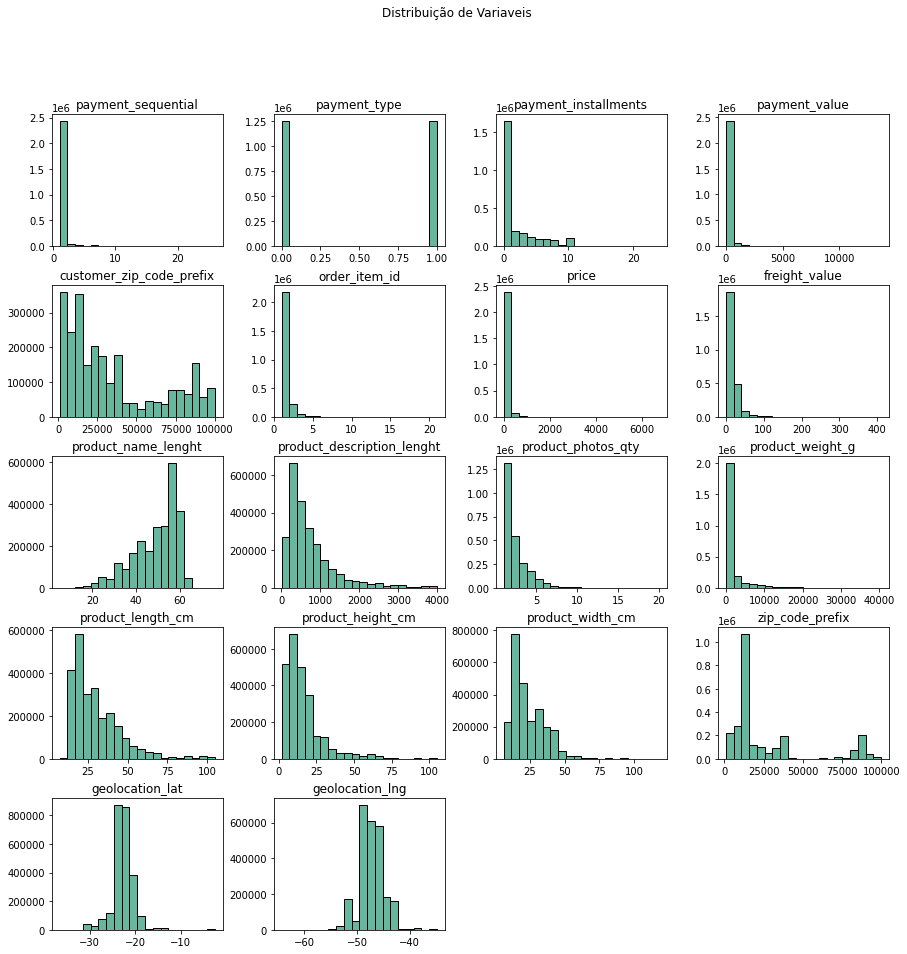

In [15]:
data.hist(figsize=(15, 15), grid=False, bins=20, ec='k', color='#67b79e')
plt.suptitle('Distribuição de Variaveis');

### 2.1.3 Variavel Categórica

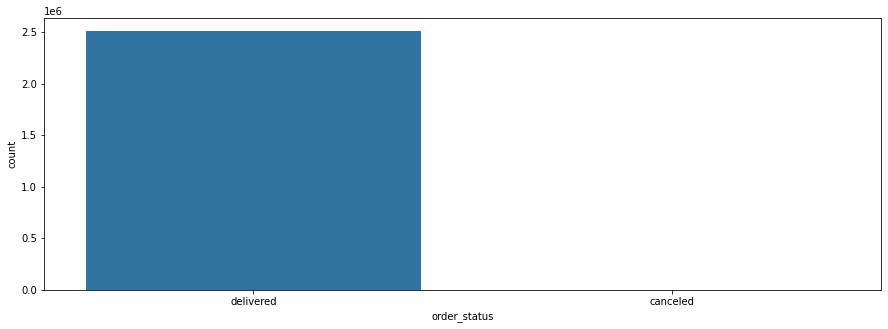

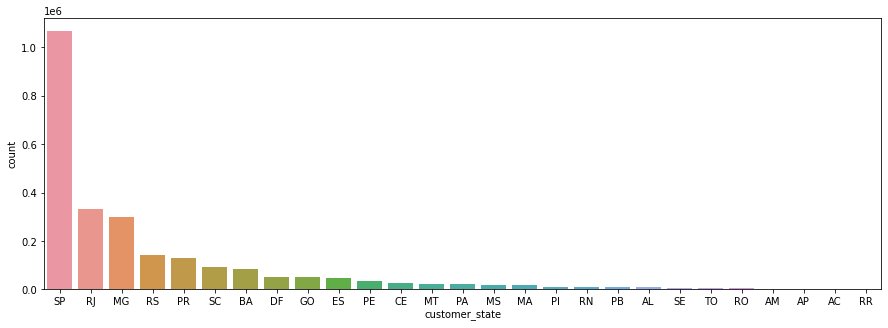

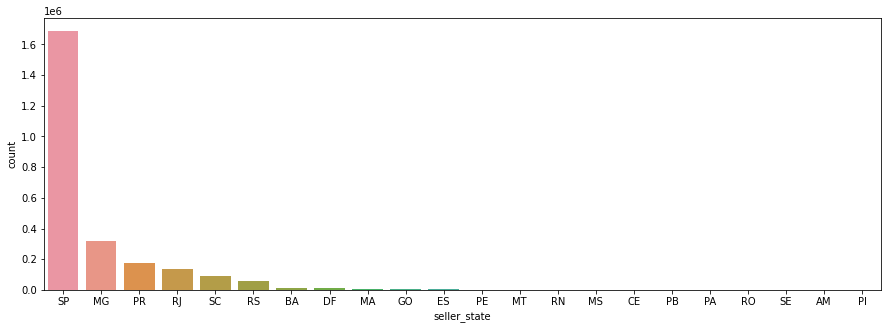

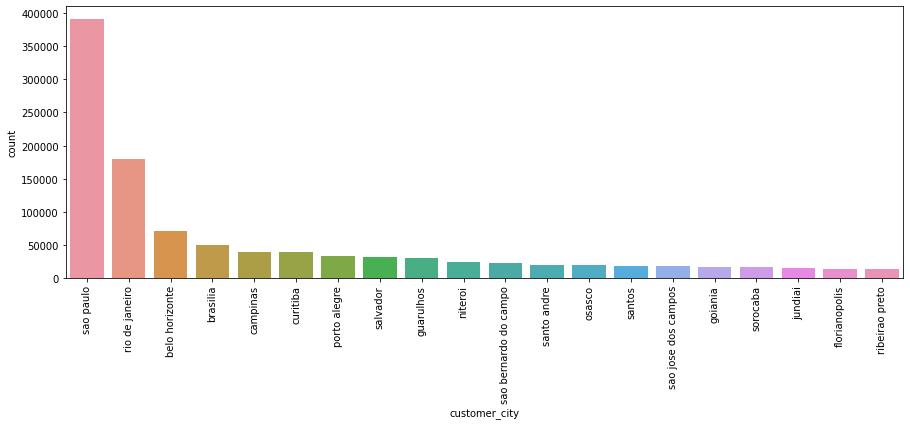

In [16]:
plt.figure(figsize=(15, 5))
sns.countplot(x='order_status', data=data);

plt.figure(figsize=(15, 5))
sns.countplot(x='customer_state', data=data, order=data['customer_state'].value_counts().sort_values(ascending=False).index);

plt.figure(figsize=(15, 5))
sns.countplot(x='seller_state', data=data, order=data['seller_state'].value_counts().sort_values(ascending=False).index);

plt.figure(figsize=(15, 5))
sns.countplot(x='customer_city', data=data, order=data['customer_city'].value_counts().sort_values(ascending=False)[:20].index)
plt.xticks(rotation=90);

## 2.1 Análise Bivariada

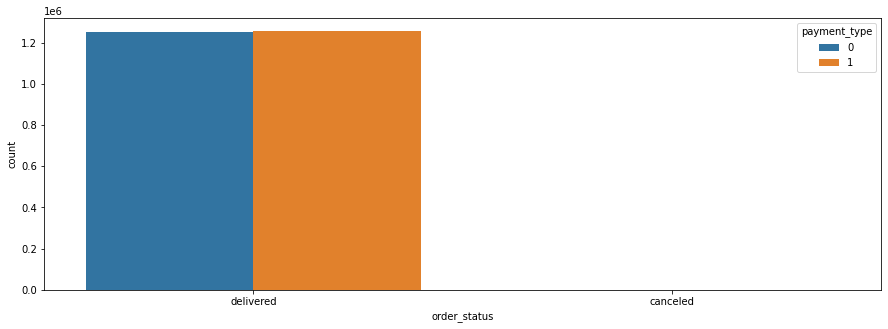

In [17]:
plt.figure(figsize=(15, 5))                         # nao usar
sns.countplot(x='order_status', hue='payment_type', data=data);

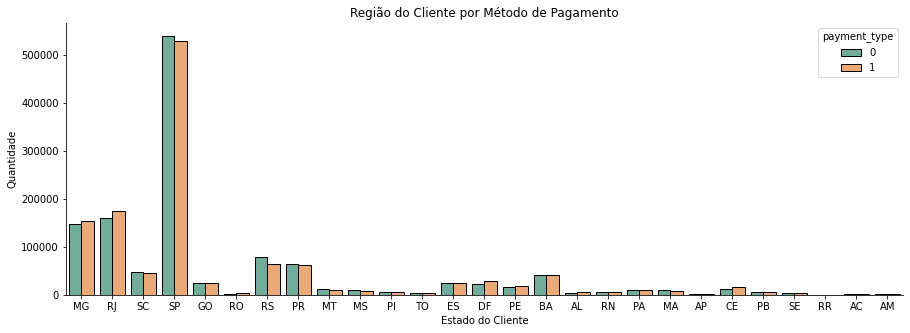

In [18]:
plt.figure(figsize=(15, 5))                                           # usar
sns.countplot(x='customer_state', hue='payment_type', data=data, ec='k', palette=['#67b79e', '#fda664'])
sns.despine(right=True)
plt.ylabel('Quantidade')
plt.xlabel('Estado do Cliente')
plt.title('Região do Cliente por Método de Pagamento');

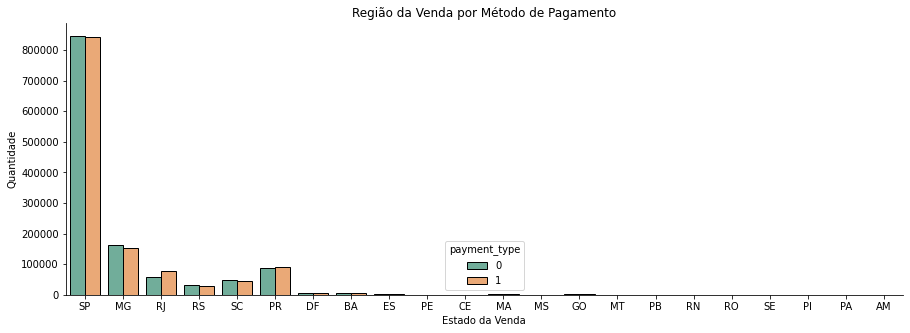

In [19]:
plt.figure(figsize=(15, 5))                                         # usar
sns.countplot(x='seller_state', hue='payment_type', data=data, ec='k', palette=['#67b79e', '#fda664'])
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Estado da Venda')
plt.title('Região da Venda por Método de Pagamento');

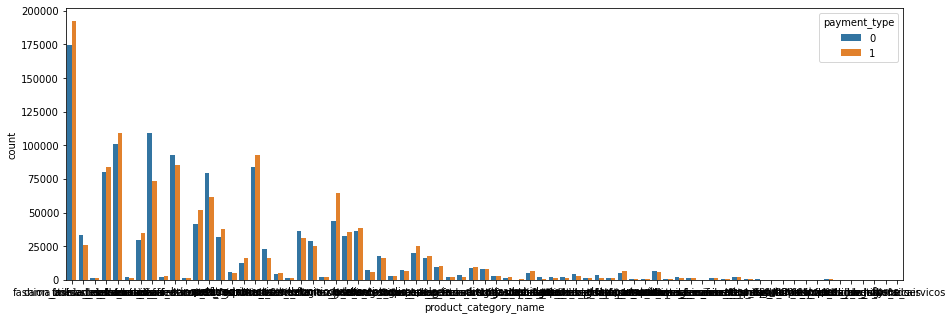

In [20]:
plt.figure(figsize=(15, 5))                                         # usar
sns.countplot(x='product_category_name', hue='payment_type', data=data);

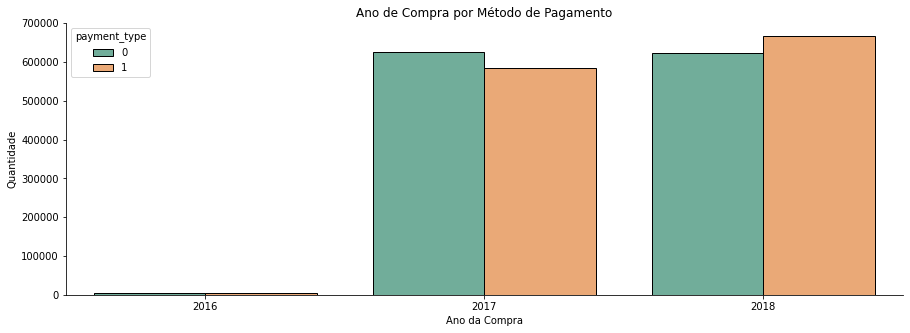

In [17]:
data['order_purchase_year'] = pd.to_datetime(data['order_purchase_timestamp']).dt.year  # USAR

plt.figure(figsize=(15, 5))
sns.countplot(x='order_purchase_year', hue='payment_type', data=data, ec='k', palette=['#67b79e', '#fda664'])
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Ano da Compra')
plt.title('Ano de Compra por Método de Pagamento');

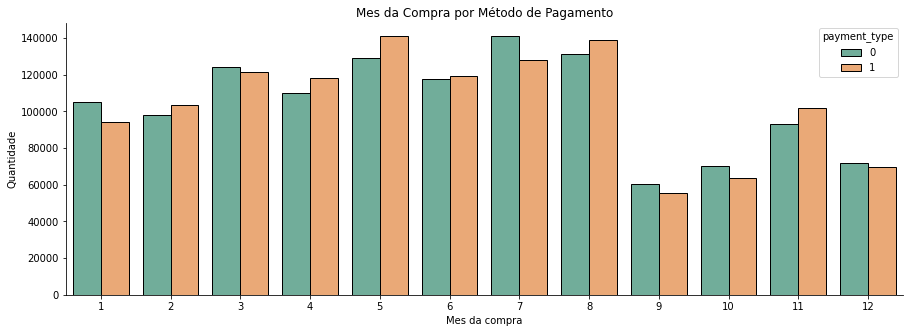

In [18]:
data['order_purchase_month'] = pd.to_datetime(data['order_purchase_timestamp']).dt.month  # USAR

plt.figure(figsize=(15, 5))
sns.countplot(x='order_purchase_month', hue='payment_type', data=data, ec='k', palette=['#67b79e', '#fda664'])
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Mes da compra')
plt.title('Mes da Compra por Método de Pagamento');

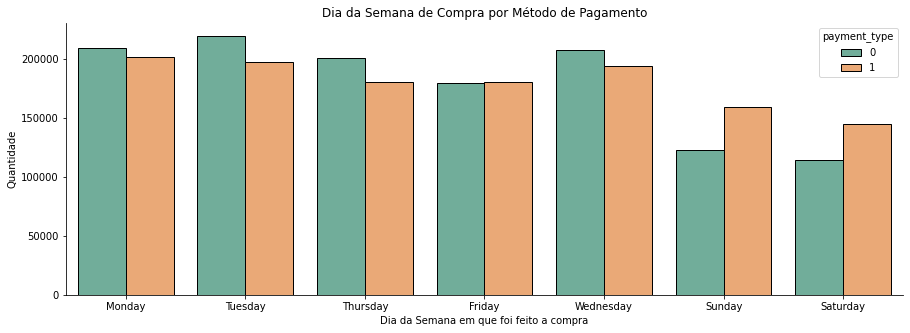

In [19]:
data['order_purchase_day_name'] = pd.to_datetime(data['order_purchase_timestamp']).dt.day_name()  # USAR

plt.figure(figsize=(15, 5))
sns.countplot(x='order_purchase_day_name', hue='payment_type', data=data, ec='k', palette=['#67b79e', '#fda664'])
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Dia da Semana em que foi feito a compra')
plt.title('Dia da Semana de Compra por Método de Pagamento');

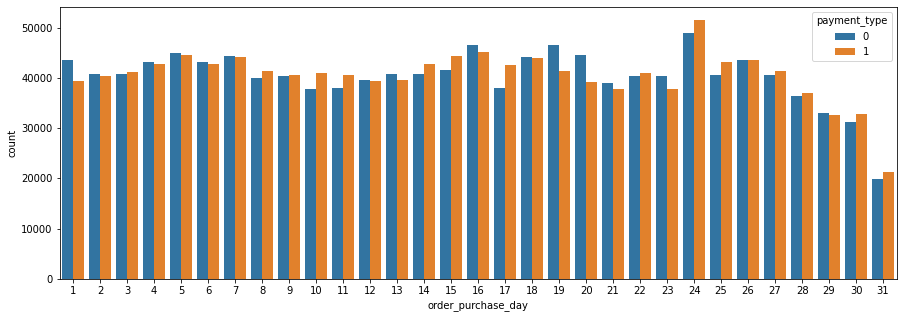

In [20]:
data['order_purchase_day'] = pd.to_datetime(data['order_purchase_timestamp']).dt.day  # USAR
    
plt.figure(figsize=(15, 5))
sns.countplot(x='order_purchase_day', hue='payment_type', data=data);

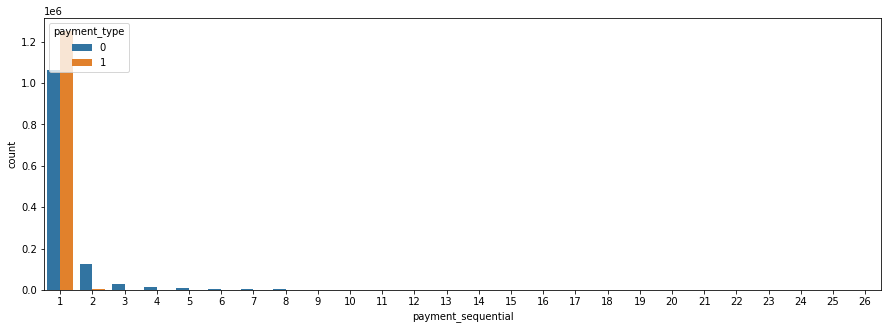

In [25]:
plt.figure(figsize=(15, 5))  # NAO USAR
sns.countplot(x='payment_sequential', hue='payment_type', data=data);

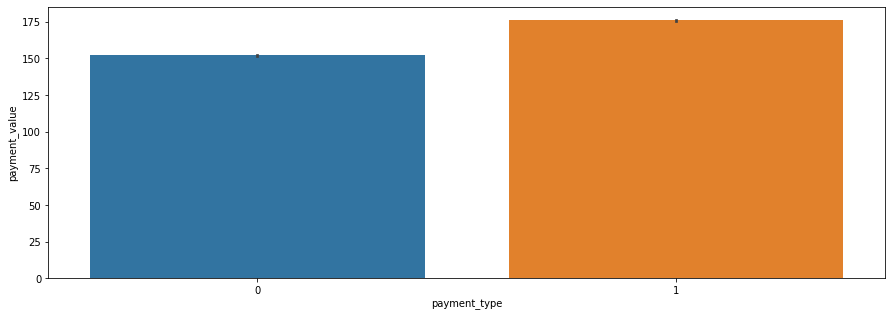

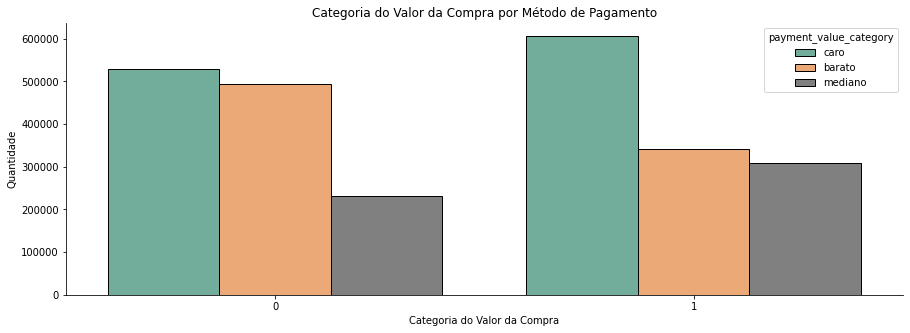

In [21]:
plt.figure(figsize=(15, 5))  # usar
sns.barplot(x='payment_type', y='payment_value', data=data);

data['payment_value_category'] =  data['payment_value'].apply(lambda x: 'barato'  if x <= 70 else
                                                                        'mediano' if x > 70 and x >= 200 else
                                                                        'caro')

plt.figure(figsize=(15, 5))  # usar
sns.countplot(x='payment_type', hue='payment_value_category', data=data, ec='k', palette=['#67b79e', '#fda664', 'gray'])  # usar
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Categoria do Valor da Compra')
plt.title('Categoria do Valor da Compra por Método de Pagamento');

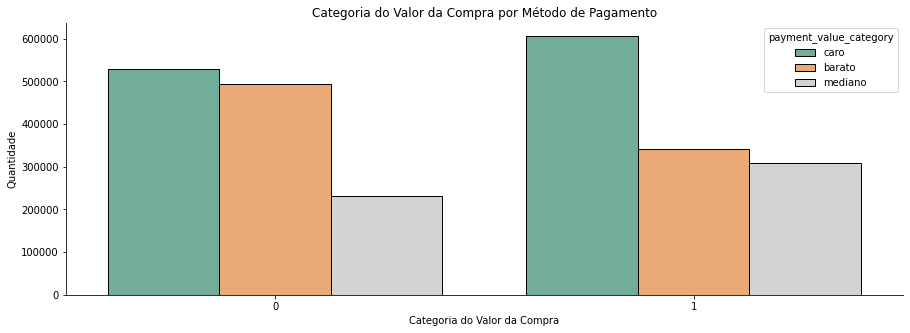

In [27]:
plt.figure(figsize=(15, 5))  # usar
sns.countplot(x='payment_type', hue='payment_value_category', data=data, ec='k', palette=['#67b79e', '#fda664', '#d3d3d3'])  # usar
plt.ylabel('Quantidade')
sns.despine(right=True)
plt.xlabel('Categoria do Valor da Compra')
plt.title('Categoria do Valor da Compra por Método de Pagamento');

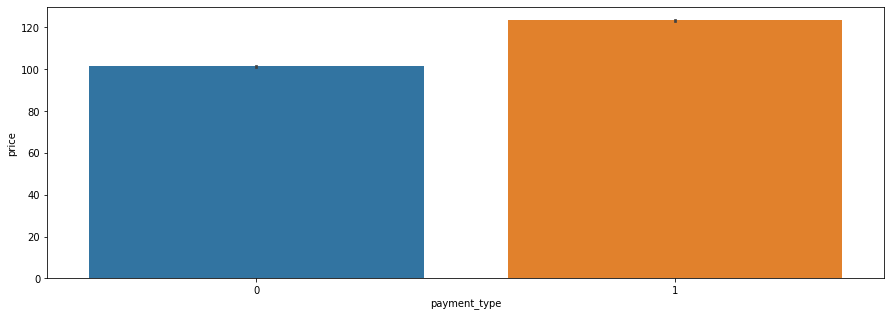

In [28]:
plt.figure(figsize=(15, 5))  
sns.barplot(x='payment_type', y='price', data=data);    # nao usar

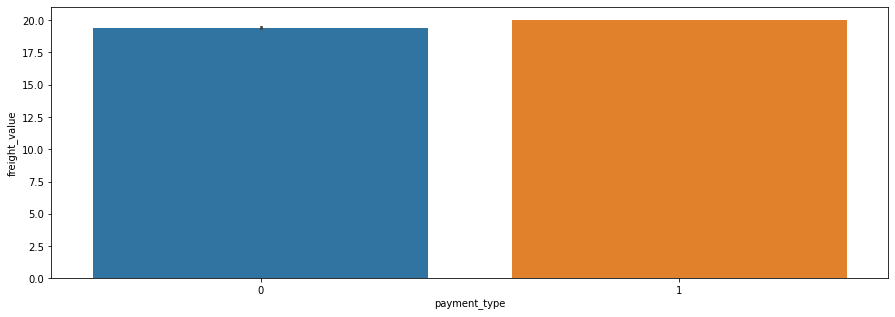

In [29]:
plt.figure(figsize=(15, 5))                                                       # nao usar
sns.barplot(x='payment_type', y='freight_value', data=data);  

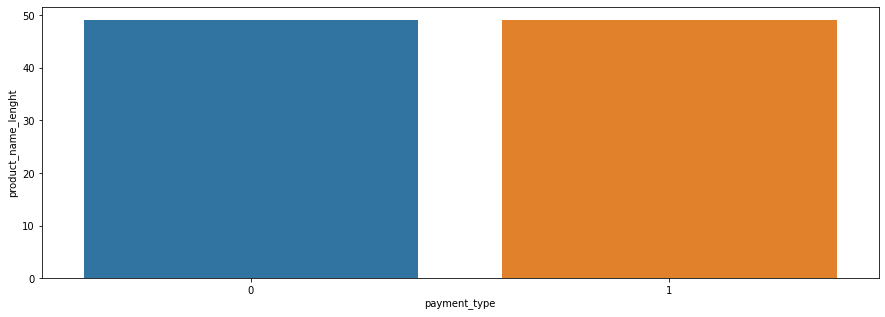

In [30]:
plt.figure(figsize=(15, 5))                                               # Nao usar
sns.barplot(x='payment_type', y='product_name_lenght', data=data);  

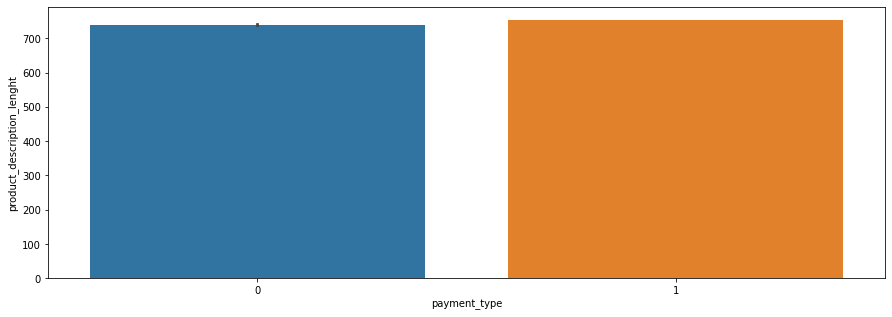

In [31]:
plt.figure(figsize=(15, 5))                                                  # Nao usar 
sns.barplot(x='payment_type', y='product_description_lenght', data=data);  

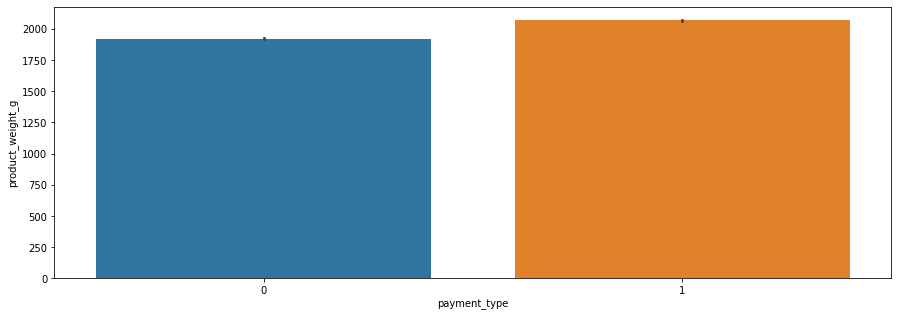

In [32]:
plt.figure(figsize=(15, 5))  
sns.barplot(x='payment_type', y='product_weight_g', data=data);        # usar

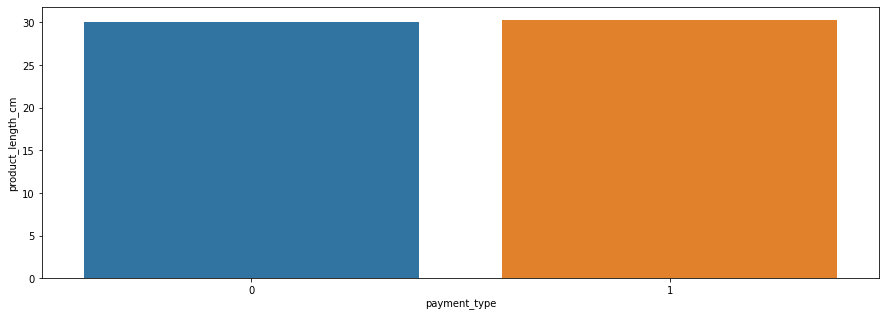

In [33]:
plt.figure(figsize=(15, 5))  
sns.barplot(x='payment_type', y='product_length_cm', data=data);  

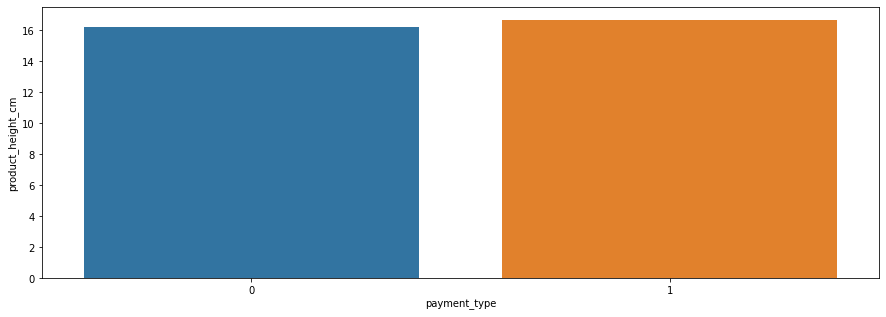

In [34]:
plt.figure(figsize=(15, 5))                                         # nao usar
sns.barplot(x='payment_type', y='product_height_cm', data=data);  

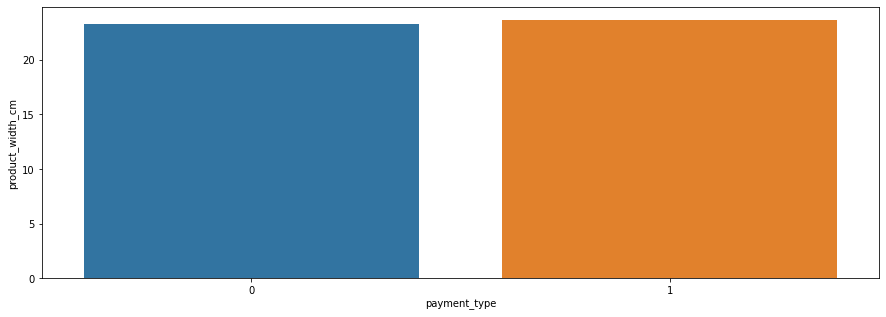

In [35]:
plt.figure(figsize=(15, 5))                                    # nao usar
sns.barplot(x='payment_type', y='product_width_cm', data=data);  

# 2.0 DIVISÃO DE DADOS


In [ ]:
data = data[['customer_state', 'seller_state', 'product_category_name', 'order_purchase_year',
            'order_purchase_month', 'order_purchase_day_name', 'order_purchase_day', 'payment_value_category',
            'payment_value', 'product_weight_g', 'payment_type']].copy()

In [22]:
# separando as variaveis
x = data.drop(columns=['payment_type']) # variaveis independentes
y = data[['payment_type']] # variavel dependente (target)

# dividindo os dados entre treino e teste (20% teste, 80% treinamento)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# tirando 5% da validação para teste do comite final
# dados de teste
x_test_y_test = pd.concat([x_test, y_test], axis=1).copy()

# tirando 5% do teste para o teste final
quantidade_linhas = x_test_y_test.shape[0]
porcentagem_teste_final = 0.5
quantidade_amostra_teste_final = round((porcentagem_teste_final * quantidade_linhas) / 100)

dados_teste_final = x_test_y_test.sample(quantidade_amostra_teste_final)
x_test_y_test = x_test_y_test.drop(list(dados_teste_final.index)).copy()

# teste
x_test = x_test_y_test.drop(columns='payment_type')
y_test = x_test_y_test['payment_type']

# teste final
x_teste_final = dados_teste_final.drop(columns='payment_type')
y_teste_final = dados_teste_final['payment_type']

# copiando dados para usar no final
x_test2 = x_test.copy()

# 3.0 PREPARAÇÃO DE DADOS

Etapa para realizar o pré-processamento das variaveis para treinar o algotritmo

## 3.1 Dados de Treino

### 3.1.1 Reescalonamento

Etapa para transformar colunas/variaveis numéricas para a mesma escala nos dados de Treino.

In [23]:
# definindo StardarScaler
payment_value        = MinMaxScaler()
product_weight_g     = MinMaxScaler()
order_purchase_year  = MinMaxScaler()
order_purchase_month = MinMaxScaler()
order_purchase_day   = MinMaxScaler()

# payment_value
x_train['payment_value'] = payment_value.fit_transform(x_train[['payment_value']].values)

# product_weight_g
x_train['product_weight_g'] = product_weight_g.fit_transform(x_train[['product_weight_g']].values)

# order_purchase_year
x_train['order_purchase_year'] = order_purchase_year.fit_transform(x_train[['order_purchase_year']].values)

# order_purchase_month
x_train['order_purchase_month'] = order_purchase_month.fit_transform(x_train[['order_purchase_month']].values)

# order_purchase_day
x_train['order_purchase_day'] = order_purchase_day.fit_transform(x_train[['order_purchase_day']].values)

### 3.1.2 Encoding

Etapa para transformar variaveis caregoricas em 0 e 1 nos dados de Treino.

In [24]:
# payment_value_category
x_train['payment_value_category'] = x_train['payment_value_category'].map({'barato': 0, 'mediano': 1, 'caro': 2})

# criando colunas de 0 e 1 para cada valor de product_category_name
x_train = pd.get_dummies(x_train, prefix='product_category_name', columns=['product_category_name'])
x_train = pd.get_dummies(x_train, prefix='customer_state', columns=['customer_state'])
x_train = pd.get_dummies(x_train, prefix='seller_state', columns=['seller_state'])
x_train = pd.get_dummies(x_train, prefix='order_purchase_day_name', columns=['order_purchase_day_name'])

## 3.2 Dados de Teste

### 3.2.1 Reescalonamento

Etapa para transformar colunas/variaveis numéricas para a mesma escala nos dados de Teste.

In [25]:
# definindo StardarScaler
payment_value2        = MinMaxScaler()
product_weight_g2     = MinMaxScaler()
order_purchase_year2  = MinMaxScaler()
order_purchase_month2 = MinMaxScaler()
order_purchase_day2   = MinMaxScaler()

# payment_value
x_test['payment_value'] = payment_value2.fit_transform(x_test[['payment_value']].values)

# product_weight_g
x_test['product_weight_g'] = product_weight_g2.fit_transform(x_test[['product_weight_g']].values)

# order_purchase_year
x_test['order_purchase_year'] = order_purchase_year2.fit_transform(x_test[['order_purchase_year']].values)

# order_purchase_month
x_test['order_purchase_month'] = order_purchase_month2.fit_transform(x_test[['order_purchase_month']].values)

# order_purchase_day
x_test['order_purchase_day'] = order_purchase_day2.fit_transform(x_test[['order_purchase_day']].values)

### 3.2.2 Encoding

Etapa para transformar variaveis caregoricas em 0 e 1 nos dados de Teste.

In [26]:
# payment_value_category
x_test['payment_value_category'] = x_test['payment_value_category'].map({'barato': 0, 'mediano': 1, 'caro': 2})

# criando colunas de 0 e 1 para cada valor de product_category_name
x_test = pd.get_dummies(x_test, prefix='product_category_name', columns=['product_category_name'])
x_test = pd.get_dummies(x_test, prefix='customer_state', columns=['customer_state'])
x_test = pd.get_dummies(x_test, prefix='seller_state', columns=['seller_state'])
x_test = pd.get_dummies(x_test, prefix='order_purchase_day_name', columns=['order_purchase_day_name'])

## 3.3 Dados de Validação

### 3.3.1 Reescalonamento

Etapa para transformar colunas/variaveis numéricas para a mesma escala nos dados de Treino.

In [31]:
# definindo StardarScaler
payment_value3        = MinMaxScaler()
product_weight_g3     = MinMaxScaler()
order_purchase_year3  = MinMaxScaler()
order_purchase_month3 = MinMaxScaler()
order_purchase_day3   = MinMaxScaler()

# payment_value
x_teste_final['payment_value'] = payment_value3.fit_transform(x_teste_final[['payment_value']].values)

# product_weight_g
x_teste_final['product_weight_g'] = product_weight_g3.fit_transform(x_teste_final[['product_weight_g']].values)

# order_purchase_year
x_teste_final['order_purchase_year'] = order_purchase_year3.fit_transform(x_teste_final[['order_purchase_year']].values)

# order_purchase_month
x_teste_final['order_purchase_month'] = order_purchase_month3.fit_transform(x_teste_final[['order_purchase_month']].values)

# order_purchase_day
x_teste_final['order_purchase_day'] = order_purchase_day3.fit_transform(x_teste_final[['order_purchase_day']].values)

### 3.3.2 Encoding

Etapa para transformar variaveis caregoricas em 0 e 1 nos dados de Treino.

In [32]:
# payment_value_category
x_teste_final['payment_value_category'] = x_teste_final['payment_value_category'].map({'barato': 0, 'mediano': 1, 'caro': 2})

# criando colunas de 0 e 1 para cada valor de product_category_name
x_teste_final = pd.get_dummies(x_teste_final, prefix='product_category_name', columns=['product_category_name'])
x_teste_final = pd.get_dummies(x_teste_final, prefix='customer_state', columns=['customer_state'])
x_teste_final = pd.get_dummies(x_teste_final, prefix='seller_state', columns=['seller_state'])
x_teste_final = pd.get_dummies(x_teste_final, prefix='order_purchase_day_name', columns=['order_purchase_day_name'])

# 4.0 IMPORTANCIA DAS VARIAVEIS

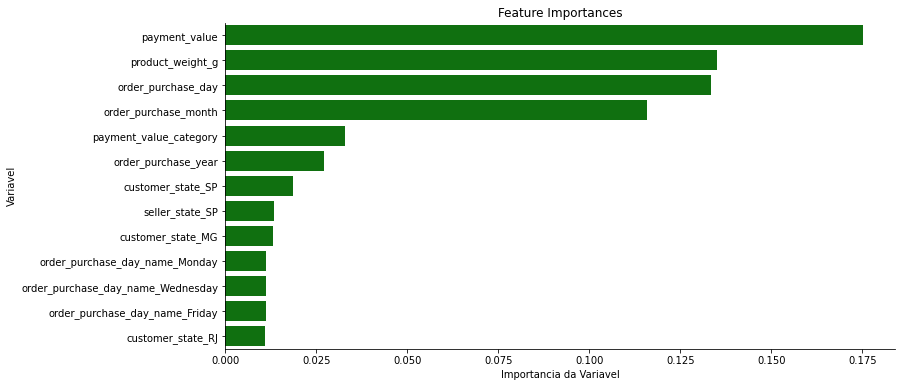

In [27]:
# define model
extraTrees = ExtraTreesClassifier()

# training model
extraTrees_trained = extraTrees.fit(x_train, y_train)

# show importance to Extra Tress
importance = extraTrees_trained.feature_importances_ 
indices = np.argsort(importance)[::-1] 

# interate to save in dataframe the importance of all columns
df = pd.DataFrame()
for i, j in zip(x_train, extraTrees_trained.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)

# sort by importance value
df = df.sort_values(by='importance', ascending=False)


# adjust color to columns selected
color = []
count = 0
for i in range(len(df)):
    count += 1
    if count <= 13: # position to columns selected
        color.append('green')
    else:
        color.append('red')

# Create figure to show feature importance  
plt.figure(figsize=(12, 6))
sns.barplot(y='feature', x='importance', data=df, order=df['feature'][:13], palette=color)
sns.despine(right=True)
plt.title('Feature Importances')
plt.xlabel('Importancia da Variavel')
plt.ylabel('Variavel');

### Filtrando somente colunas acima

In [33]:
x_train2 = x_train[['payment_value', 'product_weight_g', 'order_purchase_day', 'order_purchase_month',
                    'payment_value_category', 'order_purchase_year', 'customer_state_SP',
                    'customer_state_MG', 'seller_state_SP', 'order_purchase_day_name_Monday',
                    'order_purchase_day_name_Wednesday', 'order_purchase_day_name_Friday',
                    'customer_state_RJ']].copy()

x_test2 = x_test[['payment_value', 'product_weight_g', 'order_purchase_day', 'order_purchase_month',
                    'payment_value_category', 'order_purchase_year', 'customer_state_SP',
                    'customer_state_MG', 'seller_state_SP', 'order_purchase_day_name_Monday',
                    'order_purchase_day_name_Wednesday', 'order_purchase_day_name_Friday',
                    'customer_state_RJ']].copy()

x_teste_final2 = x_teste_final[['payment_value', 'product_weight_g', 'order_purchase_day', 'order_purchase_month',
                    'payment_value_category', 'order_purchase_year', 'customer_state_SP',
                    'customer_state_MG', 'seller_state_SP', 'order_purchase_day_name_Monday',
                    'order_purchase_day_name_Wednesday', 'order_purchase_day_name_Friday',
                    'customer_state_RJ']].copy()

# 4.0 MODELAGEM MACHINE LEARNING

Etapa para realizar o treinamento dos algoritmos/modelos para prever a forma de pagamento.

## 4.1 Arvore de Decisão

In [48]:
# definindo arvore com 11 folhas
tree = DecisionTreeClassifier(max_depth=15)

# treinando a arvore com os dados de treino
tree_treinada = tree.fit(x_train2, y_train)

# usando a arvore treinada para prever nos dados de teste
tree_predicao = tree_treinada.predict(x_test2)

## 4.2 Regressão Logistica

In [35]:
 # definindo a regressão logistica
lr = LogisticRegression()

# treinando a regressão logistica com os dados de treino
lr_treinado = lr.fit(x_train2, y_train)

# usando a regressão logistica para prever nos dados de teste
predicao_lr = lr_treinado.predict(x_test2)

## 4.3 Random Forest

In [36]:
# definindo a Random Forest
rf = RandomForestClassifier(max_depth=15)

# treinando a Random Forest com os dados de treino
rf_treinado = rf.fit(x_train2, y_train)

# usando a Random Forest para prever nos dados de teste
predicao_rf = rf_treinado.predict(x_test2)

## 4.4 Naive Bayes

In [37]:
 # definindo o Naive Bayes
bayes = GaussianNB()

# treinando o Naive Bayes com os dados de treino
bayes_treinado = bayes.fit(x_train2, y_train)

# usando o Naive Bayes para prever nos dados de teste
predicao_bayes = bayes_treinado.predict(x_test2)

## 4.5 XGBoost

In [38]:
 # definindo o XGBoost
xgb = xgb.XGBClassifier(max_depth=9)

# treinando o XGBoost com os dados de treino
xgb_treinado = xgb.fit(x_train2, y_train)

# usando o XGBoost para prever nos dados de teste
predicao_xgb = xgb_treinado.predict(x_test2)

## 4.6 LGBM

In [39]:
 # definindo o lgbm
lgbm = LGBMClassifier(max_depth=9)

# treinando o lgbm com os dados de treino
lgbm_treinado = lgbm.fit(x_train2, y_train)

# usando o lgbm para prever nos dados de teste
predicao_lgbm = lgbm_treinado.predict(x_test2)

# 5.0 VALIDAÇÃO

Etapa para validar a performance dos modelos/algoritmos.

## 5.1 Arvore de Decisão

In [61]:
confusion_matrix(y_test, tree_predicao)

array([[153665,  95827],
       [ 53209, 196632]], dtype=int64)

In [59]:
np.round(confusion_matrix(y_test, tree_predicao), 1)

array([[153665,  95827],
       [ 53209, 196632]], dtype=int64)

,Model_name,Accuracy,Precision,Recall
0,Arvore de Decisão,0.70153,0.67234,0.787029


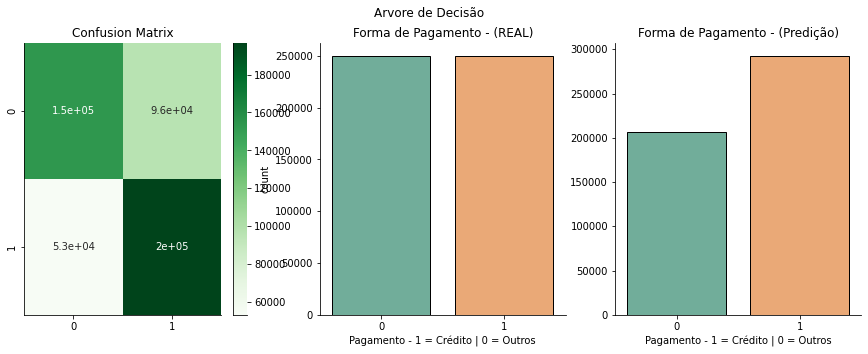

In [58]:
# Arvore de Decisao
metrics_tree = compute_metrics(model_name='Arvore de Decisão', y_validation=y_test, yhat=tree_predicao) # calcula metricas
plot_metric(y_test, tree_predicao, 'Arvore de Decisão') # graficos
metrics_tree # mostra metricas

## 5.2 Regressão Logistica

,Model_name,Accuracy,Precision,Recall
0,Regressão Logistica,0.551846,0.544264,0.64134


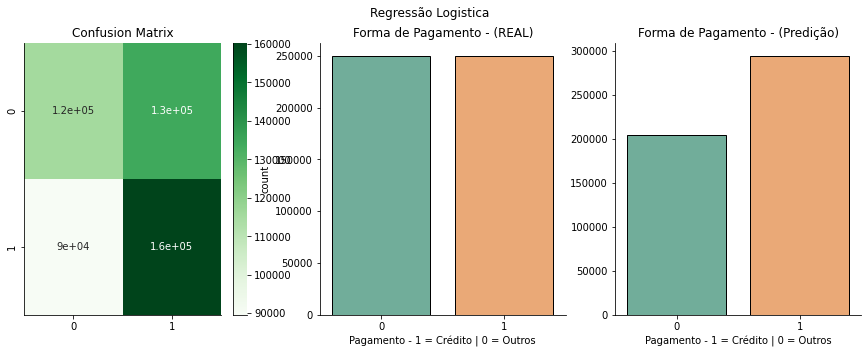

In [62]:
# Regressão Logistica
metrics_lr = compute_metrics(model_name='Regressão Logistica', y_validation=y_test, yhat=predicao_lr) # calcula metricas
plot_metric(y_test, predicao_lr, 'Regressão Logistica') # graficos
metrics_lr # mostra metricas

## 5.3 Random Forest

,Model_name,Accuracy,Precision,Recall
0,Random Forest,0.87089,0.835593,0.923703


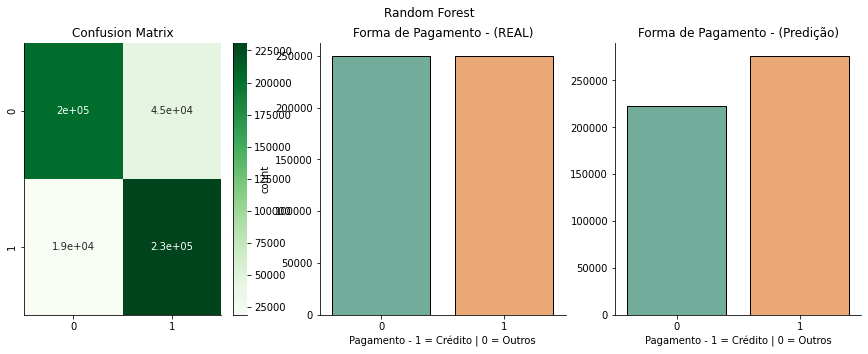

In [51]:
# Random Forest
metrics_rf = compute_metrics(model_name='Random Forest', y_validation=y_test, yhat=predicao_rf) # calcula metricas
plot_metric(y_test, predicao_rf, 'Random Forest') # graficos
metrics_rf # mostra metricas

## 5.4 Naive Bayes

,Model_name,Accuracy,Precision,Recall
0,Naive Bayes,0.550861,0.542962,0.646759


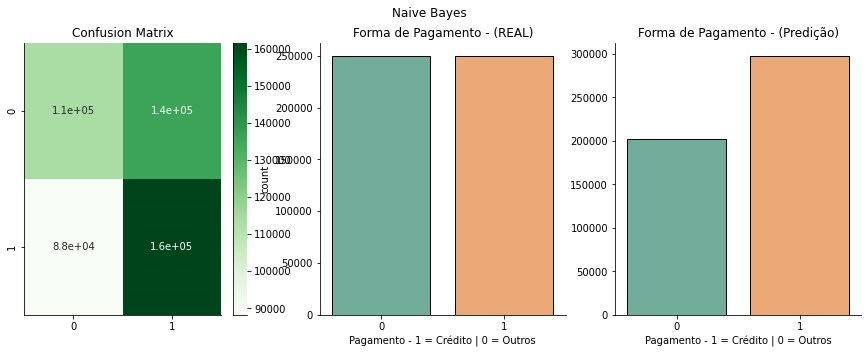

In [52]:
# Naive Bayes
metrics_bayes = compute_metrics(model_name='Naive Bayes', y_validation=y_test, yhat=predicao_bayes) # calcula metricas
plot_metric(y_test, predicao_bayes, 'Naive Bayes') # graficos
metrics_bayes # mostra metricas

## 5.5 XGBoost

,Model_name,Accuracy,Precision,Recall
0,XGBoost,0.825854,0.813944,0.845138


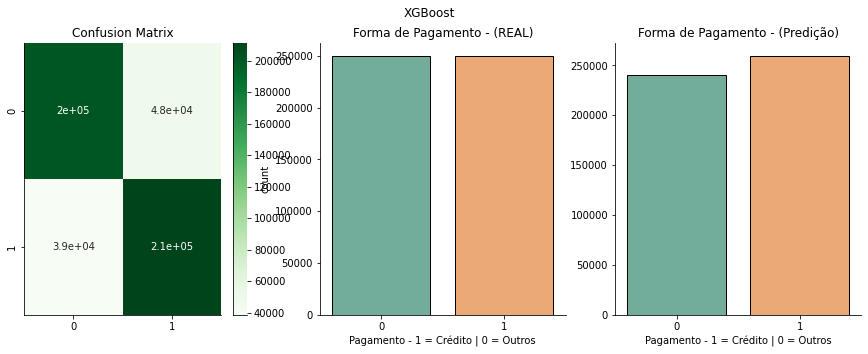

In [53]:
# XGBoost
metrics_xgboost = compute_metrics(model_name='XGBoost', y_validation=y_test, yhat=predicao_xgb) # calcula metricas
plot_metric(y_test, predicao_xgb, 'XGBoost') # graficos
metrics_xgboost # mostra metricas

## 5.6 LGBM

,Model_name,Accuracy,Precision,Recall
0,LGBM,0.630445,0.606897,0.742056


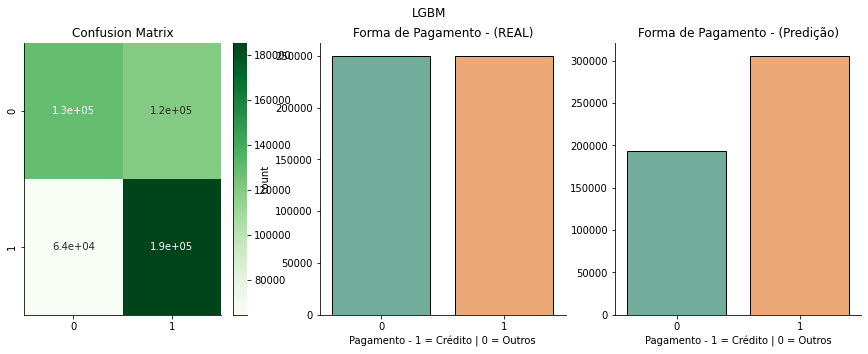

In [63]:
# LGBM
metrics_lgbm = compute_metrics(model_name='LGBM', y_validation=y_test, yhat=predicao_lgbm) # calcula metricas
plot_metric(y_test, predicao_lgbm, 'LGBM') # graficos
metrics_lgbm # mostra metricas

# 6.0 COMITÊ DE CLASSIFICADOR

## 6.1 Ajuntando Predições

Ajuntando as predições dos 3 melhores modeos:

- Arvore de Decisão
- XGBoost
- Random Forest

## 6.2 Criando Comitê

In [84]:
# melhores modelos
tree     = DecisionTreeClassifier(max_depth=15)
xgboost  = xgb.XGBClassifier(max_depth=9)
rf       = RandomForestClassifier(max_depth=15)

# comite por votação de IA
comite = VotingClassifier(
    estimators=[('tree', tree), ('xgb', xgboost), ('rf', rf)], voting='hard'
)

# treinando comite com os dados de treino
comite_treinado = comite.fit(x_train2, y_train)

# testando o comite com novos dados gerados
predicao_comite = comite_treinado.predict(x_teste_final2)

## 6.3 Validação do Comitê

,Model_name,Accuracy,Precision,Recall
0,Comitê de Classificadores,0.506178,0.499779,0.911955


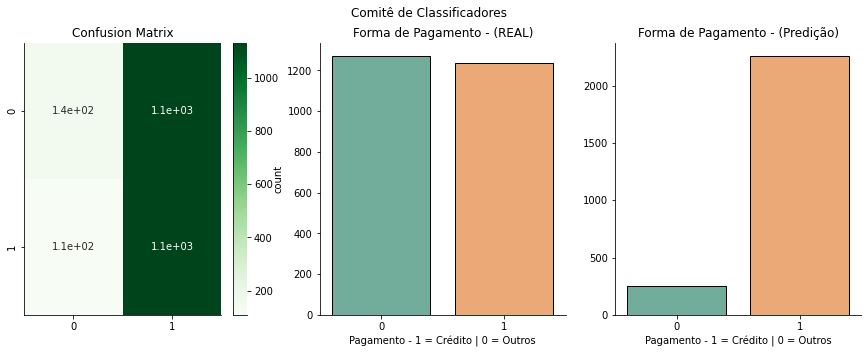

In [85]:
# comite
metrics_comite = compute_metrics(model_name='Comitê de Classificadores', y_validation=y_teste_final, yhat=predicao_comite) # calcula metricas
plot_metric(y_teste_final, predicao_comite, 'Comitê de Classificadores') # graficos
metrics_comite # mostra metricas

# 7.0 RESULTADO FINAL

Etapa para gerar a lista das pessoas que pagarão com cartão de crédito.

In [41]:
x_test2['forma_de_pagamento?'] = list(pred_modelos['comite'])

x_test2.sample(20)

,order_id,payment_sequential,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,product_height_cm,product_width_cm,zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,forma_de_pagamento?
3567927,1227f9af3b2ddb0b95060aab8e5b3dc7,1,4,47.05,53c9811a9eed9e84d267b8a929840882,delivered,2018-05-10 14:48:29,2018-05-10 15:11:25,2018-05-10 14:00:00,2018-05-18 16:21:53,...,6.0,13.0,13070.0,campinas,SP,-22.884724,-47.076555,campinas,SP,1
5879427,b196564f2fd79a80ab1b31dd8ba4e4fb,1,8,274.56,960ffb45acd270534e88387352742459,delivered,2018-06-06 21:11:57,2018-06-06 21:32:06,2018-06-08 14:13:00,2018-06-18 21:33:33,...,11.0,11.0,13170.0,sumare,SP,-22.823410,-47.271376,sumare,SP,1
15087272,33d4257aa190f034f74c6626a12b6e53,1,10,228.71,c564529ffd5238e134307140271dd186,delivered,2017-09-17 23:00:57,2017-09-17 23:10:18,2017-09-18 19:37:33,2017-10-03 20:45:01,...,22.0,19.0,9230.0,santo andre,SP,-23.615874,-46.526663,santo andre,SP,1
2171984,1f38d4b0b64e26e3aa96c3e8a4afe95e,1,3,163.02,cf25c789086e690ac0787d83feaec0fc,delivered,2018-02-13 14:33:01,2018-02-13 15:08:13,2018-02-15 05:41:44,2018-02-21 16:37:04,...,13.0,14.0,87047.0,maringa,PR,-23.420038,-51.898162,maringa,PR,1
6452744,62e62c8885c148b639ca92db8629c1ac,1,7,96.80,58aee0d0dfbc927800d152c34dc5e530,delivered,2018-02-28 10:14:05,2018-02-28 10:29:47,2018-03-02 18:59:04,2018-03-26 14:52:27,...,20.0,30.0,13232.0,campo limpo paulista,SP,-23.217996,-46.768946,campo limpo paulista,SP,1
4880276,5cc475c7c03290048eb2e742cd64cb5e,1,1,82.69,75e8f990b9e289013b1d092614b52487,delivered,2016-10-04 21:54:52,2016-10-05 03:10:31,2016-12-06 17:24:00,2016-12-12 20:31:54,...,13.0,16.0,14092.0,ribeirao preto,SP,-21.177173,-47.770507,ribeirao preto,SP,1
13291336,07bd0c7e13ac7c3a408dd3bc8f18fc78,1,1,592.18,6888824f6a0a78173ad41847d2dac2f0,delivered,2018-01-30 15:18:07,2018-02-06 17:15:32,2018-02-09 22:05:05,2018-02-14 23:06:46,...,20.0,42.0,35680.0,itauna,MG,-20.088403,-44.598949,itaúna,MG,0
10446337,dc4e9e7d17fec4c4ded41724619a1b10,1,1,45.61,a67749ad2ad8984f58af753299d89756,delivered,2018-02-05 15:22:51,2018-02-05 15:35:58,2018-02-06 17:16:37,2018-02-14 20:08:11,...,15.0,15.0,89460.0,canoinhas,SC,-26.153425,-50.392285,canoinhas,SC,1
2709519,b7624f6b70f7b79ea2b092b6f1be678c,1,4,112.99,a6b19a21cdce23baec63e5e6a0ff8288,delivered,2017-02-03 22:21:47,2017-02-03 22:30:19,2017-02-07 07:38:58,2017-06-14 14:42:22,...,48.0,38.0,37795.0,andradas,MG,-22.064461,-46.563775,andradas,MG,1
8285408,5d8e9c0a711b826b72298f9abeb269cd,1,1,35.86,b21ff624eaefac438d7923cd142bd9c5,delivered,2017-02-06 12:19:55,2017-02-08 03:15:13,2017-02-08 11:41:17,2017-02-13 15:12:46,...,2.0,11.0,15502.0,votuporanga,SP,-20.411639,-49.986775,votuporanga,SP,1
